# 07wk-2: (합성곱신경망) – CNN 핵심레이어, CNN의 학습원리, FashionMNIST

## 1. Imports

In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision

In [2]:
plt.rcParams['figure.figsize'] = (4.5, 3.0)

## 2. 주요 코드 등

In [1]:
import torch

* 편의기능

```Python
torch.einsum('nchw->ncwh', tnsr.clone()) ## 이미지 형식 텐서 변환
tnsr.squeeze() ## 값이 하나인 차원 삭제
torch.nn.functional.one_hot(y).float() ## 원-핫 인코딩
```

* 엣지 판별 컨볼루션 매트릭스

```Python
v_conv.weight.data = torch.tensor([
    [0, 0, 0, 0],
    [0, 1,-1, 0],
    [0, 1,-1, 0],
    [0, 0, 0, 0]
]).float().reshape(1, 1, 4, 4)

h_conv.weight.data = torch.tensor([
    [0, 0, 0, 0],
    [0, 1, 1, 0],
    [0,-1,-1, 0],
    [0, 0, 0, 0]
]).float().reshape(1, 1, 4, 4)
```

```Python
net = torch.nn.Sequential(
    torch.nn.Conv2d(?, 64, 5, 1, bias = True),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 4),
    
)
```

## 3. CNN 핵심레이어

### A. `torch.nn.ReLU()`

### B. `torch.nn.MaxPool2d`

> 커널 사이즈가 n인 윈도우로 나눠서 맥스값 먹임. 딱 떨어지지 않으면 짤림

### C. `torch.nn.Conv2d`

**(예시1) 연산방법, stride = 2**

In [3]:
img = torch.rand(1,1,4,4)
conv = torch.nn.Conv2d(in_channels=1,out_channels=1,kernel_size=2,stride=2)

In [4]:
conv.weight.data, conv.bias.data

(tensor([[[[-0.2809,  0.0922],
           [ 0.4339, -0.3868]]]]),
 tensor([0.1308]))

In [5]:
(img[:,  :,  :2,  :2] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0440]),
 tensor([[[[ 0.0440,  0.0137],
           [-0.0465,  0.0592]]]], grad_fn=<ConvolutionBackward0>))

In [6]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0137]),
 tensor([[[[ 0.0440,  0.0137],
           [-0.0465,  0.0592]]]], grad_fn=<ConvolutionBackward0>))

In [7]:
(img[:,  :,  :2,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0137]),
 tensor([[[[ 0.0440,  0.0137],
           [-0.0465,  0.0592]]]], grad_fn=<ConvolutionBackward0>))

In [8]:
(img[:,  :,  2:,  2:] * conv.weight.data).sum()+conv.bias.data, conv(img)

(tensor([0.0592]),
 tensor([[[[ 0.0440,  0.0137],
           [-0.0465,  0.0592]]]], grad_fn=<ConvolutionBackward0>))

> **Note**
>
> **입력이 1장의 흑백이미지이고 출력도 1장의 흑백이미지일 경우 컨볼루션
> 계산과정 요약[1]**
>
> 1.  윈도우생성: `kernel_size` = (?,?) 인 윈도우를 만듦
> 2.  sub-img생성: 입력 이미지에 윈도우를 통과시켜 (?,?) 크기의
>     sub-img를 만듦.
> 3.  연산: sub-img의 각 원소에 `conv.weight`의 값을 원소별로
>     (=element-wisely) 곱하고 결과를 더함. (만약에 `conv.bias`가 있다면
>     최종결과에 bias를 더함)
> 4.  이동&반복: 윈도우를 `stride` 만큼 이동하여 반복. (`stride`=1
>     이라면 한칸씩, `stride`=2 라면 두칸씩 이동) -> 스무딩이랑 비슷한 느낌 -> `stride`와 `kernel_size`가 똑같으면 `MaxPool2d`와 동일한 방식으로 윈도우 형성

**(예시2)** – 재현

“A guide to convolution arithmetic for deep learning” (Dumoulin and
Visin 2016) 에 나온 그림재현

-   ref: <https://arxiv.org/abs/1603.07285>

<figure class="margin-caption">
<img
src="https://github.com/guebin/2021BDA/blob/master/_notebooks/2021-11-04-conv.png?raw=true"
alt="Fig: conv2d 계산과정시각화" />
<figcaption aria-hidden="true">Fig: conv2d 계산과정시각화</figcaption>
</figure>

> 이동평균이랑 비슷한데 평균은 아닌, 가중평균도 아닌, 그냥 입맛대로 가중치를 가하고 그 가중치 합이 1도 아닌, 음수일수도 있는

`[1]` 입력 `shape = (1, 1, ?, ?)`이고 출력의 `shape = (1, 1, ?, ?)`일 경우

In [14]:
img = torch.tensor([
    [3, 3, 2, 1, 0],
    [0, 0, 1, 3, 1],
    [3, 1, 2, 2, 3],
    [2, 0, 0, 2, 2],
    [2, 0, 0, 0, 1]
]).reshape(1, 1, 5, 5).float()

In [19]:
conv = torch.nn.Conv2d(
    in_channels = 1,
    out_channels = 1,
    kernel_size = 3,
    stride = 1,
    bias = False
)

conv.weight.data = torch.tensor([
    [0, 1, 2],
    [2, 2, 0],
    [0, 1, 2]
]).reshape(1, 1, 3, 3).float() ## 학습된 파라미터

In [18]:
conv(img)

tensor([[[[12., 12., 17.],
          [10., 17., 19.],
          [ 9.,  6., 14.]]]], grad_fn=<ConvolutionBackward0>)

> 잘 됨

**(예시3) 이동평균**

In [20]:
img = torch.arange(1,17).float().reshape(1,1,4,4)
conv = torch.nn.Conv2d(1, 1, kernel_size = 2, stride = 1, bias = False)
conv.weight.data = conv.weight.data*0 + (1/4)

In [22]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]]]], grad_fn=<ConvolutionBackward0>)

**(예시4) 2개의 이미지**

`-` 개념 : (1, 1, ?, ?) $\to$ (1, 1, ?, ?)의 `conv`를 observation별로 적용

> `conv`에 포함된 파라메터의 수는 (1, 1, ?, ?) $\to$ (1, 1, ?, ?)인 경우와 (n, 1, ?, ?) $\to$ (n, 1, ?, ?)인 경우가 동일함 -> 당연히 샘플 수만 바뀐 거니까...

In [24]:
imgs = torch.arange(1, 33).float().reshape(2, 1, 4, 4)

conv = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 2, stride = 1, bias = False)
conv.weight.data = conv.weight.data*0 + (1/4)

In [28]:
conv(imgs).shape

torch.Size([2, 1, 3, 3])

**(예시5) 2개의 out_channels**

`-` 개념: (1,1,?,?) $\to$ (1,1,?,?) 의 conv를 하나의 채널에 적용, 그리고
또 다른 채널에는 (1,1,?,?) $\to$ (1,1,?,?) 인 다른 conv를 적용함.

-   `conv`에 포함된 파라메터 수는 (1,1,?,?) $\to$ (1,1,?,?) 인 경우보다
    (1,1,?,?) $\to$ (1,2,?,?)인 경우가 2배 많음 ; `bias`가 있어도 2배임

In [48]:
## 같은 데이터에 대해서 convolution을 두 번 거는 상황임 -> 파라미터 두배
img = torch.arange(1, 33).float().reshape(2, 1, 4, 4)
conv = torch.nn.Conv2d(in_channels = 1, out_channels = 2, kernel_size = 2, stride = 1, bias = False)

In [32]:
conv(img).shape

torch.Size([2, 2, 3, 3])

In [54]:
conv.weight.data[0] = conv.weight.data[0]*0 + (1/4) ## 앞에 해버리니까 안된다 -> weight 자체는 못바꾸나 그럴리가
conv.weight.data[1] = conv.weight.data[1]*0

In [55]:
conv(img)

tensor([[[[ 3.5000,  4.5000,  5.5000],
          [ 7.5000,  8.5000,  9.5000],
          [11.5000, 12.5000, 13.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]],


        [[[19.5000, 20.5000, 21.5000],
          [23.5000, 24.5000, 25.5000],
          [27.5000, 28.5000, 29.5000]],

         [[ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000]]]], grad_fn=<ConvolutionBackward0>)

## 4. CNN의 학습원리

### A. data

아래의 4개 이미지를 생각하자.

In [59]:
img0 = torch.tensor([
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
]).reshape(1, 1, 16, 16) 
img1 = 0.1-torch.einsum('nchw->ncwh', img0.clone()) ## hw를 wh로 바꿈 -> 가로 세로 바꿈
img2 = torch.zeros((1, 1, 16, 16))
for i in range(16):
    for j in range(16):
        if j <= i:  # 대각선 아래 삼각형이면 0.1(하얀색)
            img2[0, 0, i, j] = 0.1
# 빈 이미지
img3 = torch.zeros((1, 1, 16, 16))
block_size = 2
# 블록 단위로 채우기
for i in range(0, 16, block_size):
    for j in range(0, 16, block_size):
        if ((i // block_size) + (j // block_size)) % 2 == 0:
            img3[0, 0, i:i+block_size, j:j+block_size] = 0.1 ## 다 0 채워놓고 격자마다 0.1

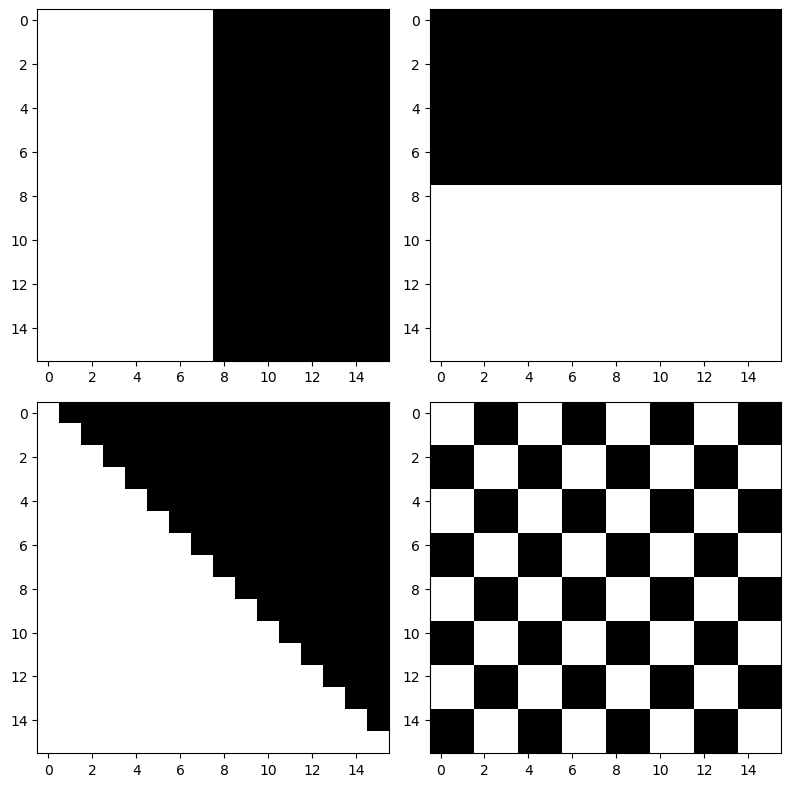

In [60]:
fig,axs = plt.subplots(2,2)
fig.set_size_inches(8,8)
axs[0][0].imshow(img0.squeeze(),cmap="gray") ## squeeze로 그냥 차원이 1인 것들은 없애버림
axs[0][1].imshow(img1.squeeze(),cmap="gray")
axs[1][0].imshow(img2.squeeze(),cmap="gray")
axs[1][1].imshow(img3.squeeze(),cmap="gray")
## 이미지 텐서 통합하고 그냥 for문 돌려서 하시지...
plt.tight_layout()

In [61]:
imgs = torch.concat([img0,img1,img2,img3])

In [62]:
imgs.shape

torch.Size([4, 1, 16, 16])

### B. 이동평균

In [107]:
m_conv = torch.nn.Conv2d(in_channels = 1, out_channels = 1, kernel_size = 4, stride = 1)
m_conv.weight.data = m_conv.weight.data*0 + (1/16)
m_conv.bias.data = m_conv.bias.data*0

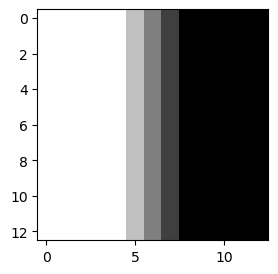

In [78]:
plt.imshow(m_conv(imgs)[0, 0, :, :].squeeze().data, cmap = "gray")

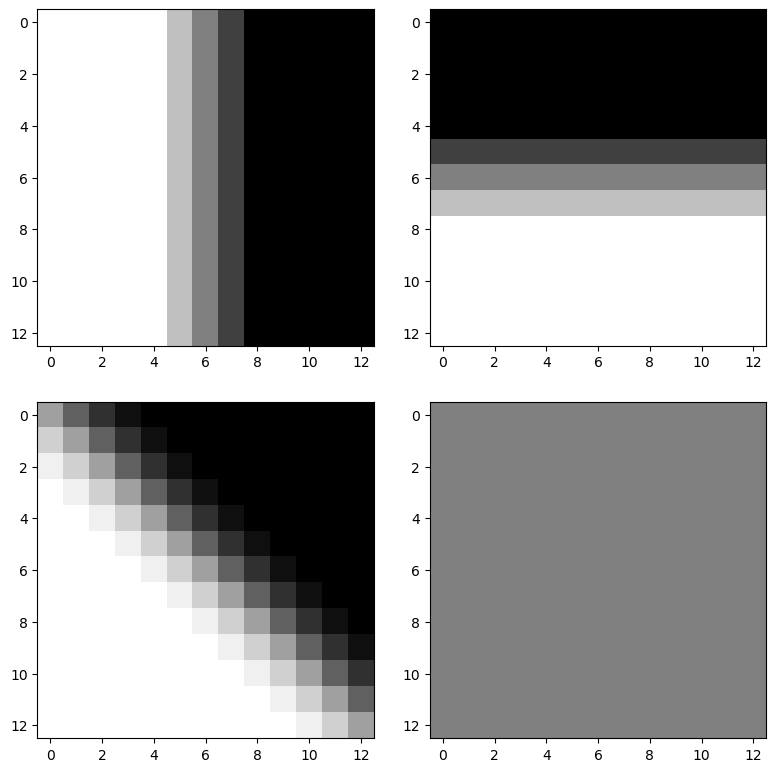

In [84]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

for i in range(4) :
    axs[i//2][i%2].imshow(m_conv(imgs)[i, 0, :, :].squeeze().data, cmap = "gray", vmin = 0, vmax = 0.1)

plt.tight_layout()

> 마지막의 경우 전부 같은 값으로 뭉개짐

In [85]:
m_conv.bias.data = m_conv.bias.data*0 + 0.05

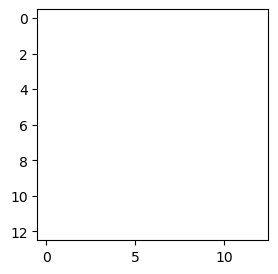

In [88]:
plt.imshow(m_conv(img3).data.squeeze(), cmap = "gray", vmin = 0, vmax = 0.1)
plt.show()

> 0.05를 전부 더해주니 이렇게 됨

### C. 세로엣지 : edge detacting

> 이걸 잘하면 물체 경계 판별하는 것도 가능할듯, 왠만해선

In [114]:
v_conv = torch.nn.Conv2d(
    in_channels = 1, 
    out_channels = 1,
    kernel_size = 4,
    bias = False
)

v_conv.weight.data = torch.tensor([
    [0, 0, 0, 0],
    [0, 1,-1, 0],
    [0, 1,-1, 0],
    [0, 0, 0, 0]
]).float().reshape(1, 1, 4, 4)

In [96]:
v_conv(img0).squeeze().data ## 0.2의 값을 가지는 횡축이 나옴

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000,

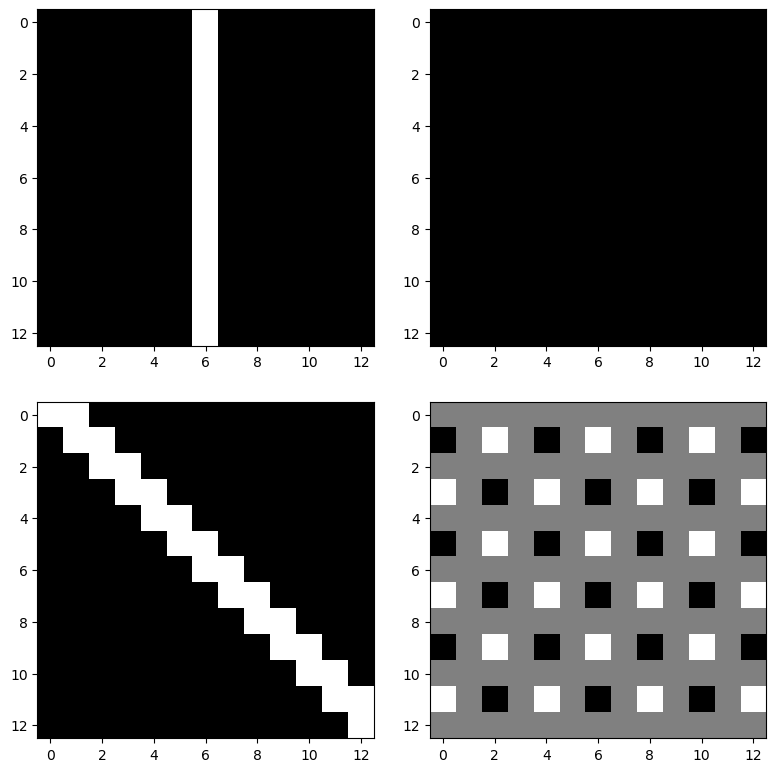

In [93]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

for i in range(4) :
    axs[i//2][i%2].imshow(v_conv(imgs)[i, 0, :, :].squeeze().data, cmap = "gray")

plt.tight_layout()

In [98]:
v_conv2 = torch.nn.Conv2d(1, 1, 2, 1, bias = False)
v_conv2.weight.data = torch.tensor([
    [-1, 1],
    [-1, 1]
]).float().reshape(1, 1, 2, 2)

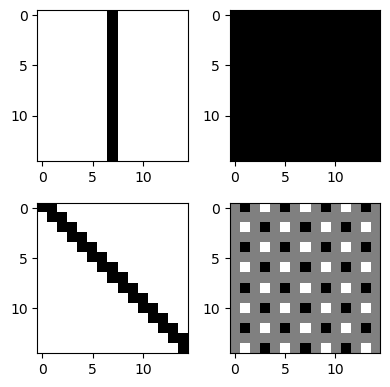

In [100]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 4)

for i in range(4) :
    axs[i//2][i%2].imshow(v_conv2(imgs)[i, 0, :, :].squeeze().data, cmap = "gray")

plt.tight_layout()

### D. 가로 엣지

In [104]:
h_conv = torch.nn.Conv2d(1, 1, 4, 1, bias = False)

h_conv.weight.data = torch.tensor([
    [0, 0, 0, 0],
    [0,-1,-1, 0],
    [0, 1, 1, 0],
    [0, 0, 0, 0],
]).float().reshape(1, 1, 4, 4)

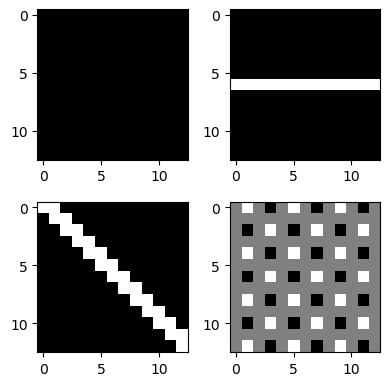

In [105]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 4)

for i in range(4) :
    axs[i//2][i%2].imshow(h_conv(imgs)[i, 0, :, :].squeeze().data, cmap = "gray")

plt.tight_layout()

> 여기서 몇 번 더, 더 다양한 필터들을 걸 수 있음

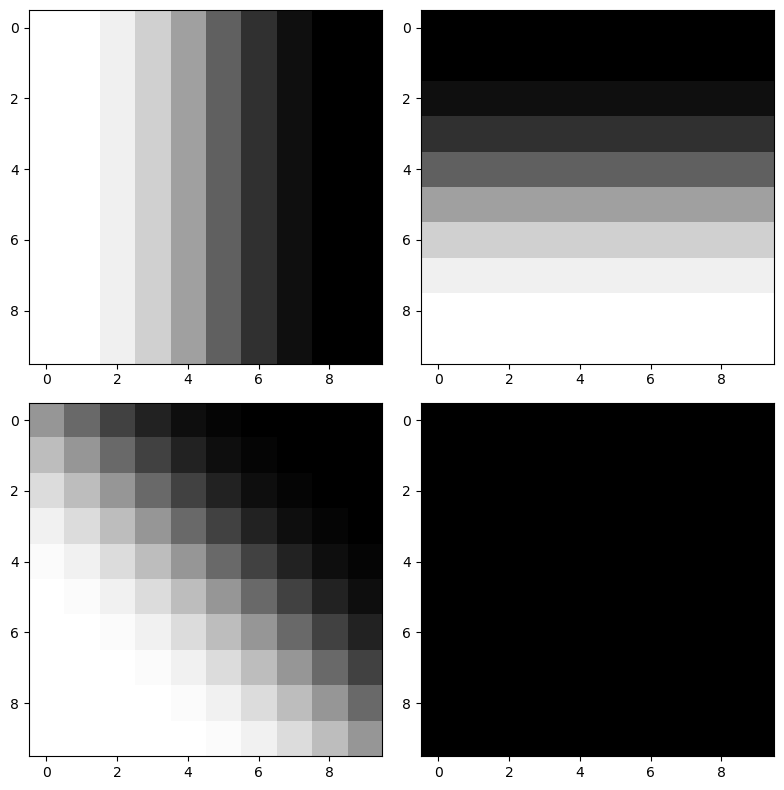

In [108]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(8, 8)

for i in range(4) :
    axs[i//2][i%2].imshow(m_conv(m_conv(imgs))[i, 0, :, :].squeeze().data, cmap = "gray")

plt.tight_layout()

### E. (C, D, E) + ReLU + MaxPool

In [109]:
m_conv(imgs).shape

torch.Size([4, 1, 13, 13])

In [110]:
mp = torch.nn.MaxPool2d(kernel_size = 13) ## 이미지 텐서에서 가장 큰 값

In [111]:
mp(m_conv(imgs)) ## 다 합쳐진 거만 맥스값이 다름

tensor([[[[0.1000]]],


        [[[0.1000]]],


        [[[0.1000]]],


        [[[0.0500]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [112]:
mp(h_conv(imgs)) ## 세로 그림만 맥스값이 0임 -> 가로선이 없음

tensor([[[[0.0000]]],


        [[[0.2000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [115]:
mp(v_conv(imgs))

tensor([[[[0.2000]]],


        [[[0.0000]]],


        [[[0.1000]]],


        [[[0.2000]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

In [117]:
relu = torch.nn.ReLU()

In [127]:
mp(relu(v_conv(imgs)))
mp(relu(h_conv(imgs)))
mp(relu(m_conv(imgs)))

tensor([[[[0.1000]]],


        [[[0.1000]]],


        [[[0.1000]]],


        [[[0.0500]]]], grad_fn=<MaxPool2DWithIndicesBackward0>)

### F. 대충 이런 구조

```
이미지 1 -> h -> ReLU -> MP => 0, ?, ?, ?
         -> v -> ReLU -> MP => ?, 0, ?, ?
         -> m -> ReLU -> MP => ?, ?, ?, 0
```
* 이미지 1 -> (h, v, m) -> ReLU -> MP
* 이미지 2 -> (h, v, m) -> ReLU -> MP
* 이미지 3 -> (h, v, m) -> ReLU -> MP
* 이미지 4 -> (h, v, m) -> ReLU -> MP

In [129]:
net = torch.nn.Sequential(
    torch.nn.Conv2d(1, 3, 4), ## 3 channel으로 확장
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 13), ## 극단적으로, 그냥 하나의 최대값만 반환
    torch.nn.Flatten() ## 이미지를 잘 먹였으니 이제 로짓으로 변환시켜서 분류시킬거임
)

net[0].weight.data = torch.concat([v_conv.weight.data,
                                   h_conv.weight.data,
                                   m_conv.weight.data], axis = 0)
net[0].bias.data = torch.tensor([0.0, 0.0, -0.05]) ## 마지막의 경우 보정을 해줘야 0이 돼서 식별 가능함

In [131]:
net[0].weight.data.shape ## 색상 채널이 바뀌는 건 아님. m_conv, h_conv, v_conv가 통합된 거임

torch.Size([3, 1, 4, 4])

In [133]:
m_conv.weight.shape

torch.Size([1, 1, 4, 4])

In [139]:
net[0].weight.data

tensor([[[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  1.0000, -1.0000,  0.0000],
          [ 0.0000,  1.0000, -1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -1.0000, -1.0000,  0.0000],
          [ 0.0000,  1.0000,  1.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  0.0000]]],


        [[[ 0.0625,  0.0625,  0.0625,  0.0625],
          [ 0.0625,  0.0625,  0.0625,  0.0625],
          [ 0.0625,  0.0625,  0.0625,  0.0625],
          [ 0.0625,  0.0625,  0.0625,  0.0625]]]])

In [142]:
net(imgs)

tensor([[2.0000e-01, 0.0000e+00, 5.0000e-02],
        [0.0000e+00, 2.0000e-01, 5.0000e-02],
        [1.0000e-01, 1.0000e-01, 5.0000e-02],
        [2.0000e-01, 2.0000e-01, 9.3132e-10]], grad_fn=<ViewBackward0>)

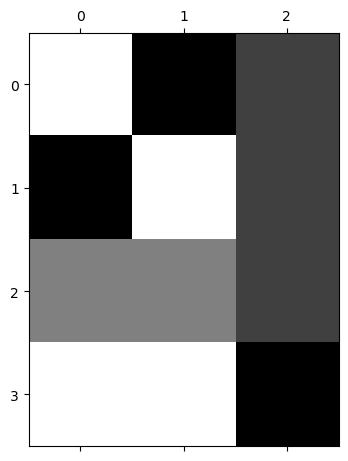

In [143]:
plt.matshow(net(imgs).data, cmap = "gray")

> 0(검은색)이 있는 것을 식별. 아무것도 없는 것도 더미변수처럼 식별

### G. MaxPool의 역할? - 선택

`-` 샘플 이미지

In [144]:
img = torch.zeros((1, 1, 16, 16))
triangle_size = 4
for i in range(triangle_size):
    for j in range(triangle_size):
        if j <= i:  # 아래 방향 직각삼각형 (왼쪽 위 꼭짓점 기준)
            img[0, 0, i, j] = 1.0

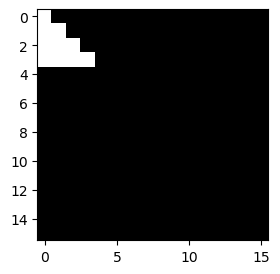

In [146]:
plt.imshow(img.squeeze(),cmap="gray")

`-` mp 1회

In [147]:
mp = torch.nn.MaxPool2d(kernel_size = 2)

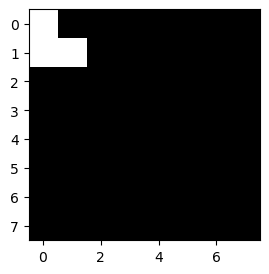

In [150]:
plt.imshow(mp(img).squeeze(),cmap="gray") ## 커널 사이즈가 크니까, 뭉둑하게 변함. 사이즈 줄어듦

> 그래도 이미지가 가지는 고유한 정보 손상되지 않았음

`-` mp 2~4회

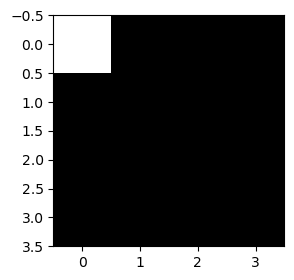

In [151]:
plt.imshow(mp(mp(img)).squeeze(),cmap="gray")

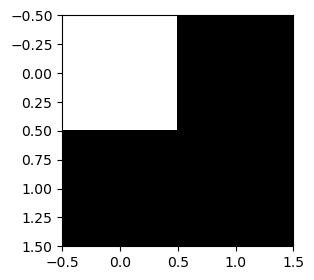

In [152]:
plt.imshow(mp(mp(mp(img))).squeeze(),cmap="gray")

> 특징이 엄청나게 커짐 -> `MaxPooling`은 이미지를 "캐리커쳐화" 한다고 비유할 수 있음. 디테일은 버리고, 중요한 특징만 뽑아서 과장되게 요약
>
> 근데 이러면 기존 피처를 다 없애버리는 게 아닌가... 아님말고...

> 컨볼루션은 그림을 뭉개는 느낌이 있지만, 얘는 중요한 정보를 손실시키지 않으려고 함

`-` CNN

--> 2D : flatten 이전 (Conv -> ReLU -> MaxPooling : 특징을 뽑고, 다변화하고, 요약한다)
-

--> 1D : 단순신경망
-

## 5. FashionMNIST

`-` 데이터

In [153]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
train_dataset = torch.utils.data.Subset(train_dataset, range(5000))
to_tensor = torchvision.transforms.ToTensor()
X = torch.stack([to_tensor(img) for img, lbl in train_dataset]).to("cuda:0")
y = torch.tensor([lbl for img, lbl in train_dataset])
y = torch.nn.functional.one_hot(y).float().to("cuda:0")

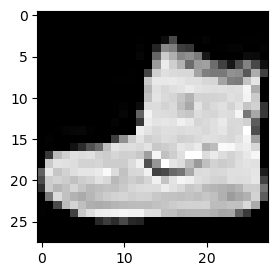

In [154]:
plt.imshow(X[0].squeeze().cpu(), cmap = "gray")

`-` 2d를 처리하고 flatten하는 네트워크

In [161]:
net1 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 5), ## out_channel에서 복잡도 확보
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size = 2), ## 커널 사이즈는 몰라요. 그냥 하이퍼 파라미터임
    ##-----여기서 한번 더 위 레이어를 반복할 수 있음-----##
    torch.nn.Flatten()
).to("cuda:0")

In [162]:
net1(X).shape

torch.Size([5000, 2304])

> 일단 16개의 캐릭터가 이미지를 잘 구분하리라고 생각하는거임

`-` 1d를 처리하는 네트워크

In [163]:
net2 = torch.nn.Sequential(
    torch.nn.Linear(2304, 10), ## 변수 23040 + 2304 여기 층을 늘릴바엔 컨볼루션을 더 잘 하겠단 마인드...
    # torch.nn.Linear(2304, 512),
    # torch.nn.ReLU(),
    # torch.nn.Linear(512, 0)
).to("cuda:0")

In [165]:
net2(net1(X)).shape

torch.Size([5000, 10])

`-` 두 네트워크를 결합

In [166]:
net = torch.nn.Sequential(
    net1,
    net2
)

loss_fn = torch.nn.CrossEntropyLoss() ## MultiClassification
optimizr = torch.optim.Adam(net.parameters())

In [167]:
##---##
for epoc in range(100) :
    netout = net(X) ## logits
    loss = loss_fn(netout, y)
    loss.backward()
    optimizr.step()
    optimizr.zero_grad()

In [172]:
(net(X).argmax(axis = 1) == y.argmax(axis = 1)).float().mean()

tensor(0.8736, device='cuda:0')

> 아무튼 네트워크를 설계할 때, `Conv2d`, `MaxPool2d`, `Flatten`, `Linear`, `ReLU`가 각각 뭘 하는지를 알아야